## In case, the file import data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reference paper

Wavelet Neural Network(WNN)
- https://www.researchgate.net/publication/237036240_EOG_Artifact_Removal_using_a_Wavelet_Neural_Network

## Reference for the data
- https://data.mendeley.com/datasets/wb6yvr725d/4

    - EEG electrodes (Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, T6, Fz, Cz, Pz) were placed according to the 10–20 International System,
    - Sampling frequency = 200 Hz
    - Bandpass filter at 0.5-40Hz
    - Notch filter at 50 Hz
    - Each dataset has 30 seconds duration
    - OAs occur due to eye moment and eye-blinks and have freuqncy ranges of 0-7 Hz and 8-13 Hz

## Select 1st dataset (54 subjects * each has 19 EEG channels + 2 EOG channels)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io
import scipy.signal
import seaborn as sns; sns.set_style("darkgrid") # styling
import pywt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
from keras.callbacks import CSVLogger

number_subjects = 54
initial_fs = 200
EEG_electrodes = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 
                  'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

initial_pure_dataset = scipy.io.loadmat("Datasets/semi_EEG-EOG/Pure_Data.mat")
initial_cont_dataset = scipy.io.loadmat("Datasets/semi_EEG-EOG/Contaminated_Data.mat")
initial_HEOG = scipy.io.loadmat("Datasets/semi_EEG-EOG/HEOG.mat")
initial_VEOG =scipy.io.loadmat("Datasets/semi_EEG-EOG/VEOG.mat")

In [ ]:
def createSubplot(n):
    fig,axs = plt.subplots(n,figsize=(15,8))
    fig.tight_layout(pad=3.0)
    return fig,axs

### Calculte FFT
def next_pow2(x):
    return 1<<(x-1).bit_length()

def calculate_FFT(inputSignal, fs, n_zeropad=0, window="False", timescaling=1):
    
    my_signal = inputSignal.copy()
    
    if window != "False":
        window = get_window(window, inputSignal.shape[0])
        my_signal *= window # multiply signal by window to reduce fluctuation in frequency-domain
        
    time_zeropadding =  np.hstack((my_signal, np.zeros(int(n_zeropad)))) # zero-padding in time-domain
    nfft = time_zeropadding.shape[0]           # get the number of samples in the signal
#     nfft = next_pow2(nfft)                                     # FFT is more efficient when using number of samples is part of power of 2
    fft = np.fft.fft(my_signal,nfft)[:int(np.ceil(nfft/2))]             # extract only the 1st half of the result (one-side frequency
    fft = fft*2                                                # multiply magnitude by 2 after select only one-side frequency
    corr_mag_fft = np.abs(fft)/nfft * (nfft / my_signal.shape[0]) / timescaling

    df = fs/nfft                                   # finding frequency resolution
    xfft = np.arange(0, fs/2,df)                   # correcting x-axis
    
    return xfft, corr_mag_fft

In [ ]:
def ExtractOnlyEEG(dict_inputEEG):
    outputEEG = dict()
    for key, value in dict_inputEEG.items():
        if key not in ['__header__', '__version__', '__globals__']:
            outputEEG[key] = value
    return outputEEG

extracted_pure_eeg = ExtractOnlyEEG(initial_pure_dataset)
extracted_cont_eeg = ExtractOnlyEEG(initial_cont_dataset)
extracted_HEOG = ExtractOnlyEEG(initial_HEOG)
extracted_VEOG = ExtractOnlyEEG(initial_VEOG)

def findMinumumEEGLength(dict_inputEEG):
    minEEGLength = int()
    for idx, eeg_values in enumerate(dict_inputEEG.values()):
        EEGLength = eeg_values.shape[-1]
        if idx == 0:
            minEEGLength = EEGLength
        elif minEEGLength > EEGLength:
            minEEGLength = EEGLength
    return minEEGLength

minEEGLength = findMinumumEEGLength(extracted_cont_eeg)
print(f"Minumum EEG length: {minEEGLength}")

# sampling frequency = 200 Hz and 26 seconds
selectedEEGLength = 200 * 26
print(f"Selected EEG length: {selectedEEGLength}")

Minumum EEG length: 5401
Selected EEG length: 5200


In [ ]:
def SelectLengthChannel(dict_inputEEG, selectEEGLength):
    """
    selectEEGChannel get an index according to the data's channels information like Fp1 = '0'
    """
    dict_oneChannelEEG = dict()
    for key, value in dict_inputEEG.items():
        dict_oneChannelEEG[key] = value[:, :selectEEGLength]
    return dict_oneChannelEEG

selectedLength_pureEEG = SelectLengthChannel(dict_inputEEG=extracted_pure_eeg,
                                              selectEEGLength=selectedEEGLength)
selectedLength_contEEG = SelectLengthChannel(dict_inputEEG=extracted_cont_eeg,
                                              selectEEGLength=selectedEEGLength)
selectedLength_HEOG = SelectLengthChannel(dict_inputEEG=extracted_HEOG,
                                              selectEEGLength=selectedEEGLength)
selectedLength_VEOG = SelectLengthChannel(dict_inputEEG=extracted_VEOG,
                                              selectEEGLength=selectedEEGLength)

print(f"Number of subjects: {len(list(extracted_pure_eeg.keys()))}")
print(f"The number of samples of contaminated EEG in one subject: {selectedLength_contEEG['sim1_con'].shape}")

Number of subjects: 54
The number of samples of contaminated EEG in one subject: (19, 5200)


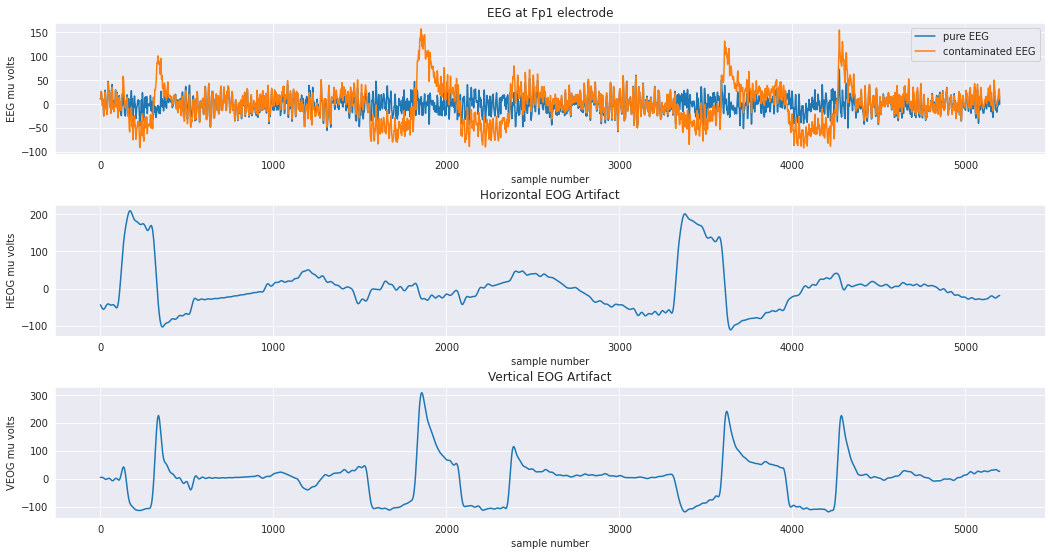

In [ ]:
index_selected_electrode = 0

# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
plt.plot(selectedLength_pureEEG["sim1_resampled"][index_selected_electrode], label="pure EEG") 
plt.plot(selectedLength_contEEG["sim1_con"][index_selected_electrode], label="contaminated EEG") 
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(selectedLength_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(selectedLength_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

# SRGAN

In [ ]:
def scaling_eeg(inputs, max_bf, min_bf, max_af, min_af):
    """
    Scaling eeg with the relative value accord multiple channels
    Think about the amplitude between the maximum values of 
    eye blink at Fp1 and normal eeg signal at Oz

    max_af = maximum value in inputs after normalize
    min_af = minimum value in inputs after normalize
    max_bf = maximum value in inputs before normalize
    min_bf = minimum value in inputs before normalize
    """ 
    scaled_inputs = ((max_af - min_af) * (inputs - min_bf) / (max_bf - min_bf)) + min_af
    scaler = [max_bf, min_bf, max_af, min_af]
    return scaled_inputs, scaler

def descaling_eeg(scaled_inputs, scaler):
    max_bf, min_bf, max_af, min_af = scaler
    de_scaled_inputs = ((scaled_inputs - min_af) * (max_bf - min_bf) / (max_af - min_af)) + min_bf
    return de_scaled_inputs

In [ ]:
np_cont_eeg = []
np_pure_eeg = []

for key, value in selectedLength_contEEG.items():
    np_cont_eeg.append(value)
np_cont_eeg = np.array(np_cont_eeg)

for key, value in selectedLength_pureEEG.items():
    np_pure_eeg.append(value)
np_pure_eeg = np.array(np_pure_eeg)

# Scaling
scaled_cont_eeg, cont_scaler = scaling_eeg(np_cont_eeg, 
                                           max_bf=np.max(np_cont_eeg), min_bf=np.min(np_cont_eeg),
                                           max_af =1, min_af=-1)
scaled_pure_eeg, pure_scaler = scaling_eeg(np_pure_eeg, 
                                           max_bf=np.max(np_cont_eeg), min_bf=np.min(np_cont_eeg),
                                           max_af =1, min_af=-1)

# De-scaling
de_scaled_cont_eeg = descaling_eeg(scaled_cont_eeg, scaler=cont_scaler)
de_scaled_pure_eeg = descaling_eeg(scaled_pure_eeg, scaler=pure_scaler)

# Split
split_subjs = 40
train_cont_eeg = scaled_cont_eeg
eval_cont_eeg = scaled_cont_eeg
train_cleaned_eeg = scaled_pure_eeg
eval_cleaned_eeg = scaled_pure_eeg

# train_cont_eeg = scaled_cont_eeg[:split_subjs]
# eval_cont_eeg = scaled_cont_eeg[split_subjs:]
# train_cleaned_eeg = scaled_pure_eeg[:split_subjs]
# eval_cleaned_eeg = scaled_pure_eeg[split_subjs:]

# train_cont_eeg, scaler = scaling_eeg(np_cont_eeg[:split_subjs], max_af =1, min_af=-1)
# eval_cont_eeg = scaling_eeg(np_cont_eeg[split_subjs:], max_af =1, min_af=-1)
# train_cleaned_eeg = scaling_eeg(np_pure_eeg[:split_subjs], max_af =1, min_af=-1)
# eval_cleaned_eeg = scaling_eeg(np_pure_eeg[split_subjs:], max_af =1, min_af=-1)

In [ ]:
print(np.max(train_cont_eeg))
print(np.max(eval_cont_eeg))
print(np.max(train_cleaned_eeg))
print(np.max(eval_cleaned_eeg))

print(np.min(train_cont_eeg))
print(np.min(eval_cont_eeg))
print(np.min(train_cleaned_eeg))
print(np.min(eval_cleaned_eeg))

1.0
1.0
1.020086
1.020086
-1.0
-1.0
-0.9966336
-0.9966336


(5200,)
(5200,)


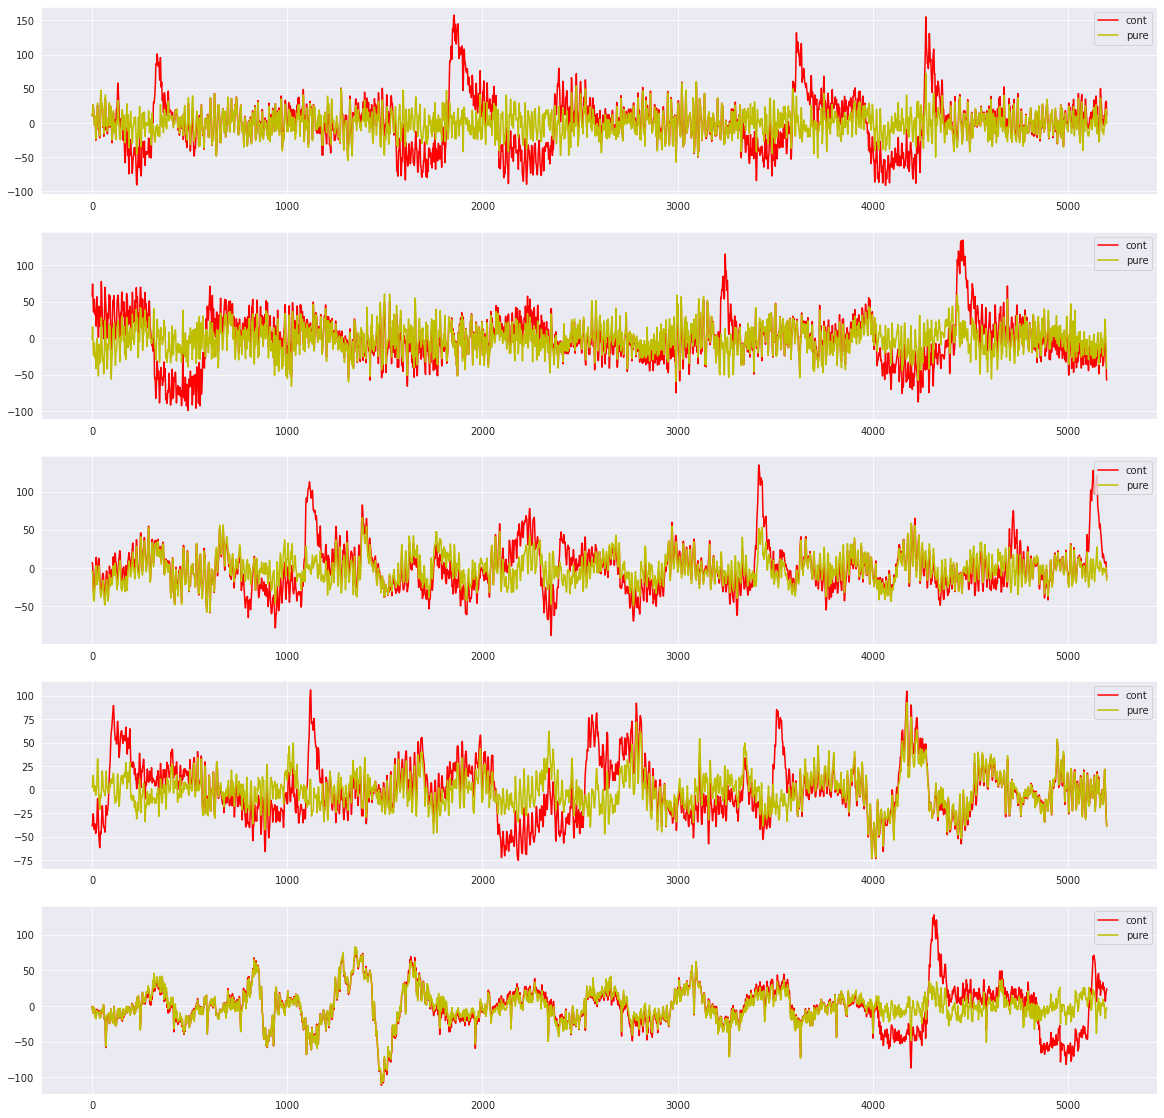

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = np_cont_eeg[idx_segment, idx_ch, :]
        e_pure = np_pure_eeg[idx_segment, idx_ch, :]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].legend(loc='upper right')
        # axs[idx_row].set_ylim(-0.6,0.6)
        
print(e_cont.shape)
print(e_pure.shape)

plt.show()

(5200,)
(5200,)


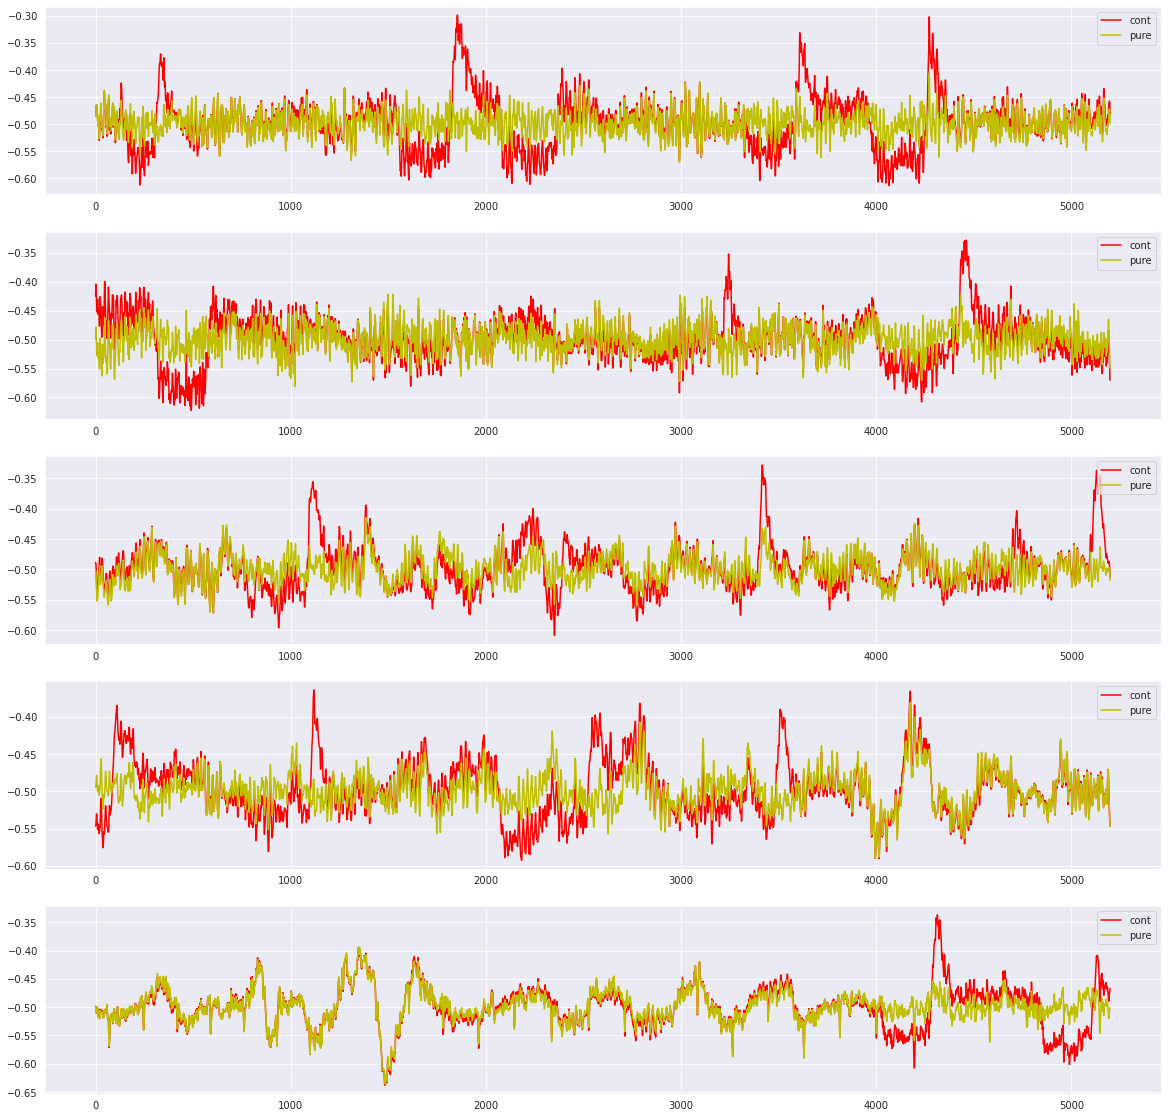

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = scaled_cont_eeg[idx_segment, idx_ch, :]
        e_pure = scaled_pure_eeg[idx_segment, idx_ch, :]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].legend(loc='upper right')
        # axs[idx_row].set_ylim(-0.6,0.6)
        
print(e_cont.shape)
print(e_pure.shape)

plt.show()

(5200,)
(5200,)


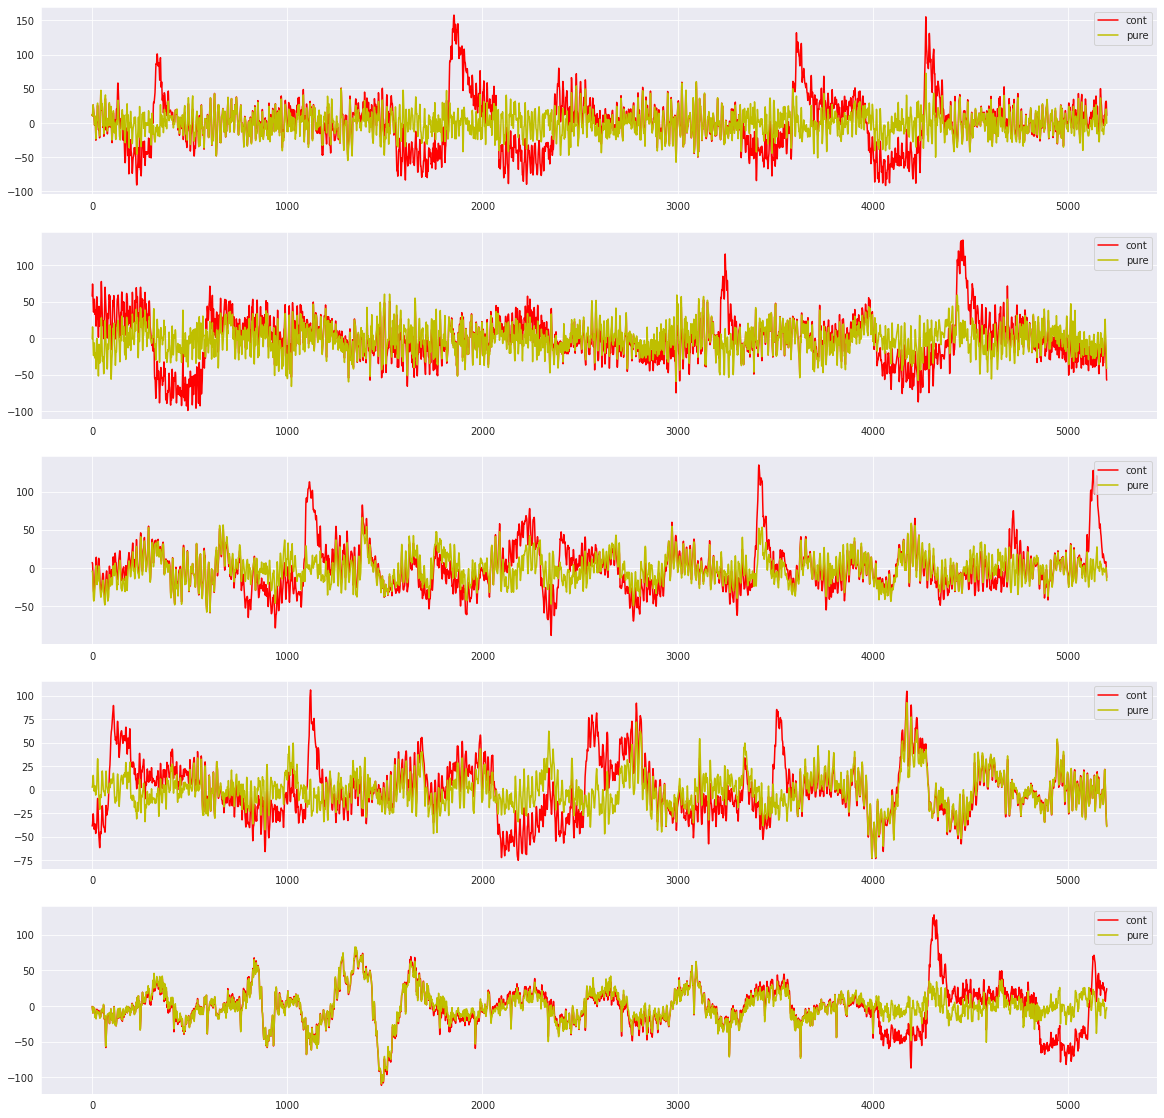

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = de_scaled_cont_eeg[idx_segment, idx_ch, :]
        e_pure = de_scaled_pure_eeg[idx_segment, idx_ch, :]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].legend(loc='upper right')
        # axs[idx_row].set_ylim(-0.6,0.6)
        
print(e_cont.shape)
print(e_pure.shape)

plt.show()

In [ ]:
print(train_cont_eeg.shape)
print(eval_cont_eeg.shape)
print(train_cleaned_eeg.shape)
print(eval_cleaned_eeg.shape)

(54, 19, 5200)
(54, 19, 5200)
(54, 19, 5200)
(54, 19, 5200)


(5200,)
(5200,)


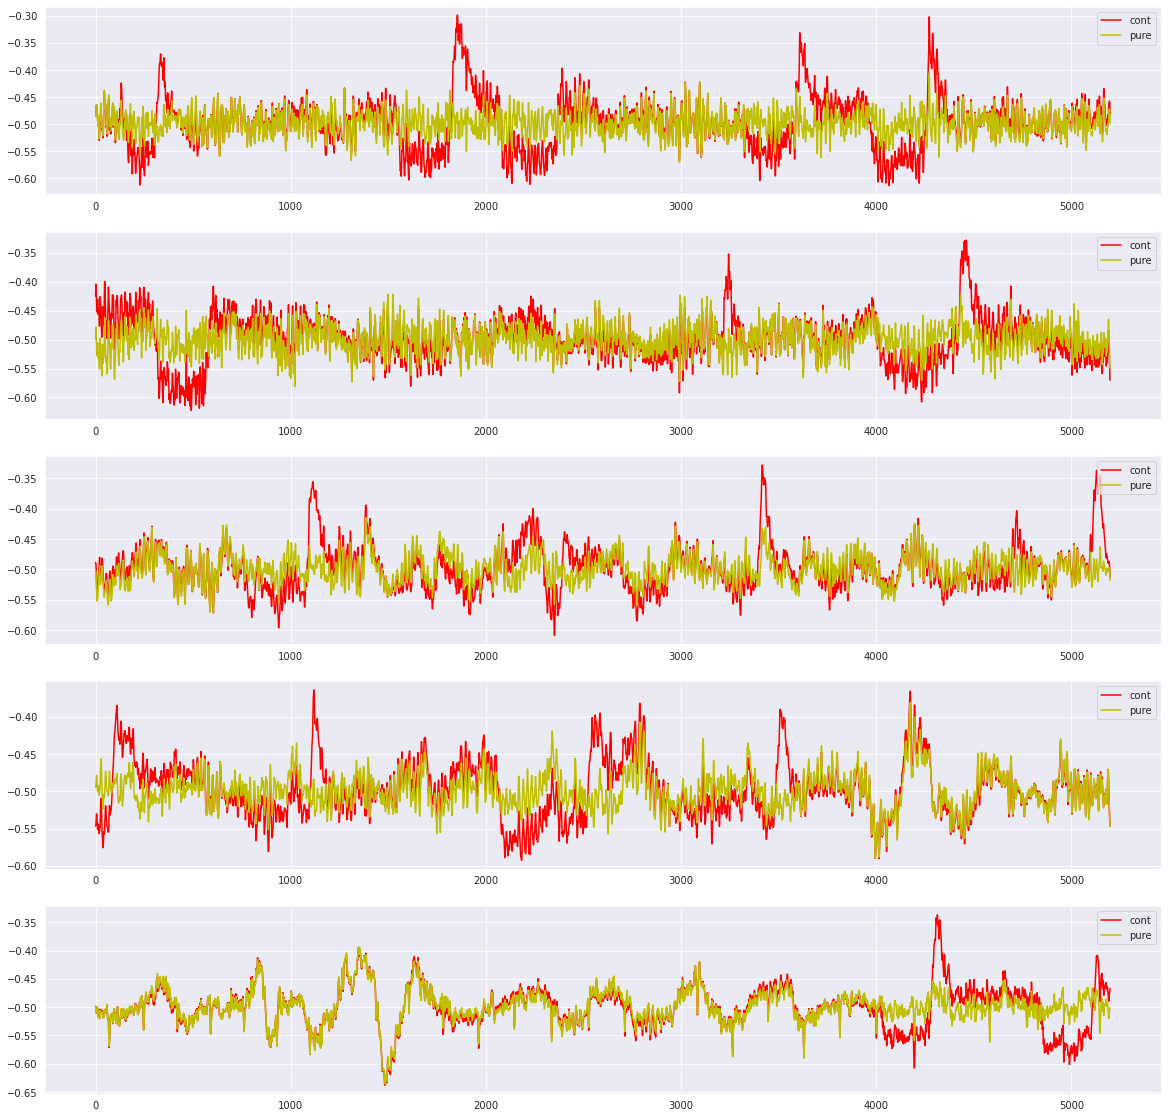

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = train_cont_eeg[idx_segment, idx_ch, :]
        e_pure = train_cleaned_eeg[idx_segment, idx_ch, :]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].legend(loc='upper right')
        # axs[idx_row].set_ylim(-0.6,0.6)
        
print(e_cont.shape)
print(e_pure.shape)

plt.show()

In [ ]:
def segmentation(in_signals, new_seg_duration, sfreq):

    n_epochs = in_signals.shape[0]
    out_data = []
    # Possible segments per epoch
    pos_segs = in_signals.shape[-1] // (new_seg_duration * sfreq)

    for idx_e_epoch in range(n_epochs):
        for idx_e_seg in range(pos_segs):
            start_index = int(idx_e_seg * sfreq)
            end_index = int(start_index + sfreq)

            # Select a segment
            e_segment = in_signals[idx_e_epoch, :, start_index:end_index]
            # Append
            out_data.append(e_segment)

    return np.array(out_data)

In [ ]:
sfreq_after_epoch = initial_fs

# Segment each epoch into 1s segment
train_cont_1s_seg = segmentation(in_signals=train_cont_eeg, new_seg_duration=1, sfreq=sfreq_after_epoch)
eval_cont_1s_seg = segmentation(in_signals=eval_cont_eeg, new_seg_duration=1, sfreq=sfreq_after_epoch)
train_cleaned_1s_seg = segmentation(in_signals=train_cleaned_eeg, new_seg_duration=1, sfreq=sfreq_after_epoch)
eval_cleaned_1s_seg = segmentation(in_signals=eval_cleaned_eeg, new_seg_duration=1, sfreq=sfreq_after_epoch)

In [ ]:
print(np.all(train_cont_1s_seg[0,:,0:200] == train_cont_eeg[0,:,0:200]))
print(np.all(train_cont_1s_seg[1,:,0:200] == train_cont_eeg[0,:,200:400]))
print(np.all(train_cont_1s_seg[28,:,0:200] == train_cont_eeg[1,:,400:600]))

True
True
True


In [ ]:
print(train_cont_1s_seg.shape)
print(eval_cont_1s_seg.shape)
print(train_cleaned_1s_seg.shape)
print(eval_cleaned_1s_seg.shape)

(1404, 19, 200)
(1404, 19, 200)
(1404, 19, 200)
(1404, 19, 200)


### Implemetation of **Dataset class** 
(for DataLoader)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io

from sklearn.preprocessing import MinMaxScaler

import scipy

import seaborn as sns

import os
import re

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, cont_eeg, clean_eeg):
        super(EEGDataset, self).__init__()
        self.cont_data = cont_eeg
        self.clean_data = clean_eeg

    def __getitem__(self, idx):
        cont_eeg = torch.tensor(self.cont_data[idx, :, :]).float()
        clean_eeg = torch.tensor(self.clean_data[idx, :, :]).float()
        return torch.unsqueeze(cont_eeg, 2), torch.unsqueeze(clean_eeg, 2)

    def __len__(self):
        return self.cont_data.shape[0]

### EEGANET

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.models import vgg19
import math


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=(1,3), stride=1, padding='same'),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=(1,3), stride=1, padding='same'),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    # in_channels, out_channels is #channel of dataset
    def __init__(self, in_channels=19, out_channels=19, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=(1,9), stride=1, padding='same'), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=(1,3), stride=1, padding='same'), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=(1,9), stride=1, padding='same'), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        # out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, input_len, n_eeg_chs = self.input_shape
        patch_h, patch_w = int(input_len / 2 ** 4), int(n_eeg_chs / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=(1, 3), stride=1, padding='same'))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=(1, 3), stride=2, padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        # layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))
        self.model = nn.Sequential(*layers)
        self.after_discrim_block = nn.Sequential(
            nn.Linear(math.ceil(input_len / 16) * 512, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        x = self.model(img)
        x = x.flatten(start_dim=1)
        return self.after_discrim_block(x)
        # return self.model(img)

In [ ]:
epoch = 0
n_epochs = 500
# dataset_name = 
batch_size = 16
lr = 0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 100
n_cpu = 2 # Old is 8
channels = 19 # Change according to #channel of dataset
sample_len = 200

omega = 5e-4

# Possibly unused!
sample_interval = 100
checkpoint_interval = 1
# hr_height = 
# hr_width = 

In [ ]:
cuda = torch.cuda.is_available()

# hr_shape = (hr_height, hr_width)

# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, sample_len, 1))
#feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
#feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
#criterion_content = torch.nn.L1Loss()
criterion_MSE = criterion_GAN

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    # feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    # criterion_content = criterion_content.cuda()

if epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/generator_%d.pth"))
    discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# dataloader = DataLoader(
#     ImageDataset("../../data/%s" % dataset_name, hr_shape=hr_shape),
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=n_cpu,
# )

print(train_cont_1s_seg.shape)
print(eval_cont_1s_seg.shape)
print(train_cleaned_1s_seg.shape)
print(eval_cleaned_1s_seg.shape)

train_dataset = EEGDataset(cont_eeg=train_cont_1s_seg, clean_eeg=train_cleaned_1s_seg)

ld_cont_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=n_cpu
)


(1404, 19, 200)
(1404, 19, 200)
(1404, 19, 200)
(1404, 19, 200)


In [ ]:
# ----------
#  Training
# ----------

for epoch in range(epoch, n_epochs):
    for i, (cont_eeg, clean_eeg) in enumerate(ld_cont_train):

        # # Configure model input
        # imgs_lr = Variable(imgs["lr"].type(Tensor))
        # imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = torch.ones(cont_eeg.shape[0], 1, requires_grad=False)
        fake = torch.zeros(cont_eeg.shape[0], 1, requires_grad=False)
        if cuda:
          cont_eeg = cont_eeg.to("cuda")
          clean_eeg = clean_eeg.to("cuda")
          valid = valid.to("cuda")
          fake = fake.to("cuda")

        # ------------------
        #  Train Generators
        # ------------------
        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_clean_eeg = generator(cont_eeg)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_clean_eeg), valid)

        # Content loss
        # gen_features = feature_extractor(gen_hr)
        # real_features = feature_extractor(imgs_hr)
        # loss_content = criterion_content(gen_features, real_features.detach())
        loss_mse = criterion_MSE(gen_clean_eeg, clean_eeg)

        # Total loss
        #loss_G = loss_content + 1e-3 * loss_GAN
        loss_G = loss_mse + omega * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(clean_eeg), valid)
        loss_fake = criterion_GAN(discriminator(gen_clean_eeg.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(ld_cont_train), loss_D.item(), loss_G.item())
        )

        batches_done = epoch * len(ld_cont_train) + i
        # if batches_done % sample_interval == 0:
        #     # Save image grid with upsampled inputs and SRGAN outputs
        #     imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
        #     gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
        #     imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
        #     img_grid = torch.cat((imgs_lr, gen_hr), -1)
        #     save_image(img_grid, "images/%d.png" % batches_done, normalize=False)

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), f"SRGAN_metrics_00_{n_epochs}_epochs/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), f"SRGAN_metrics_00_{n_epochs}_epochs/discriminator_%d.pth" % epoch)

Streaming output truncated to the last 5000 lines.
[Epoch 443/500] [Batch 16/88] [D loss: 0.008953] [G loss: 0.000516]
[Epoch 443/500] [Batch 17/88] [D loss: 0.017120] [G loss: 0.000477]
[Epoch 443/500] [Batch 18/88] [D loss: 0.001095] [G loss: 0.000539]
[Epoch 443/500] [Batch 19/88] [D loss: 0.005698] [G loss: 0.000523]
[Epoch 443/500] [Batch 20/88] [D loss: 0.003483] [G loss: 0.000528]
[Epoch 443/500] [Batch 21/88] [D loss: 0.000040] [G loss: 0.000531]
[Epoch 443/500] [Batch 22/88] [D loss: 0.000494] [G loss: 0.000532]
[Epoch 443/500] [Batch 23/88] [D loss: 0.002065] [G loss: 0.000517]
[Epoch 443/500] [Batch 24/88] [D loss: 0.036016] [G loss: 0.000477]
[Epoch 443/500] [Batch 25/88] [D loss: 0.004789] [G loss: 0.000510]
[Epoch 443/500] [Batch 26/88] [D loss: 0.040177] [G loss: 0.000520]
[Epoch 443/500] [Batch 27/88] [D loss: 0.000092] [G loss: 0.000558]
[Epoch 443/500] [Batch 28/88] [D loss: 0.003940] [G loss: 0.000522]
[Epoch 443/500] [Batch 29/88] [D loss: 0.008911] [G loss: 0.00048

### Evaluation

In [ ]:
selected_epoch = n_epoch-1

# load model class
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, sample_len, 1))
# load model's parameters
generator.load_state_dict(torch.load(f"SRGAN_metrics_00_{n_epochs}_epochs/generator_{selected_epoch}.pth"))
discriminator.load_state_dict(torch.load(f"SRGAN_metrics_00_{n_epochs}_epochs/discriminator_{selected_epoch}.pth"))

# put model to selceted device
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

NameError: ignored

In [ ]:
print(type(generator))
print(type(discriminator))

<class '__main__.GeneratorResNet'>
<class '__main__.Discriminator'>


In [ ]:
# Denoise training
train_dataset = EEGDataset(cont_eeg=train_cont_1s_seg, clean_eeg=train_cleaned_1s_seg)

ld_cont_eval = DataLoader(
    train_dataset, 
    batch_size=1, 
    shuffle=False, 
    num_workers=n_cpu
)

# ----------
# Evaluating
# ----------
generator.eval()
discriminator.eval()

train_denoised_1s_eeg = []

with torch.no_grad():
    for i, (cont_eeg, clean_eeg) in enumerate(ld_cont_eval):
        if cuda:
            cont_eeg = cont_eeg.to("cuda")
            clean_eeg = clean_eeg.to("cuda")

        # Generate a high resolution image from low resolution input
        e_denoised_eeg = generator(cont_eeg)
        # GPU to CPU
        e_denoised_eeg = e_denoised_eeg.cpu().detach().numpy()
        # Change type
        e_denoised_eeg = np.float64(e_denoised_eeg)
        train_denoised_1s_eeg.append(e_denoised_eeg)
        # break
    train_denoised_1s_eeg = np.array(train_denoised_1s_eeg)

In [ ]:
print(type(train_cont_1s_seg))
print(type(train_cleaned_1s_seg))
print(type(train_denoised_1s_eeg))

print(train_cont_1s_seg.shape)
print(train_cleaned_1s_seg.shape)
print(train_denoised_1s_eeg.shape)

# Reduce dimensions
train_denoised_1s_eeg = train_denoised_1s_eeg.squeeze(1).squeeze(-1)
print(train_denoised_1s_eeg.shape)

# Combine 26 of 1-s epochs to a 26s epoch
skip_rate = 26

train_denoised_eeg = []
n_4s_seg = train_denoised_1s_eeg.shape[0]

for idx_e_seg in range(0,n_4s_seg,skip_rate):
    start_idx = idx_e_seg
    end_idx = start_idx + skip_rate
    list_1s_segs = train_denoised_1s_eeg[start_idx:end_idx, :, :]
    combined_segment = np.concatenate(list_1s_segs, axis=-1)
    train_denoised_eeg.append(combined_segment)

train_denoised_eeg = np.array(train_denoised_eeg)
print(train_denoised_eeg.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1404, 19, 200)
(1404, 19, 200)
(1404, 1, 19, 200, 1)
(1404, 19, 200)
(54, 19, 5200)


In [ ]:
train_denoised_eeg.shape

(54, 19, 5200)

In [ ]:
print(train_cont_eeg.shape)
print(train_cleaned_eeg.shape)
print(train_denoised_eeg.shape)

print(train_cont_eeg.dtype)
print(train_cleaned_eeg.dtype)
print(train_denoised_eeg.dtype)

# print(train_cont_events.shape)

(54, 19, 5200)
(54, 19, 5200)
(54, 19, 5200)
float64
float32
float64


(5200,)
(5200,)
(5200,)


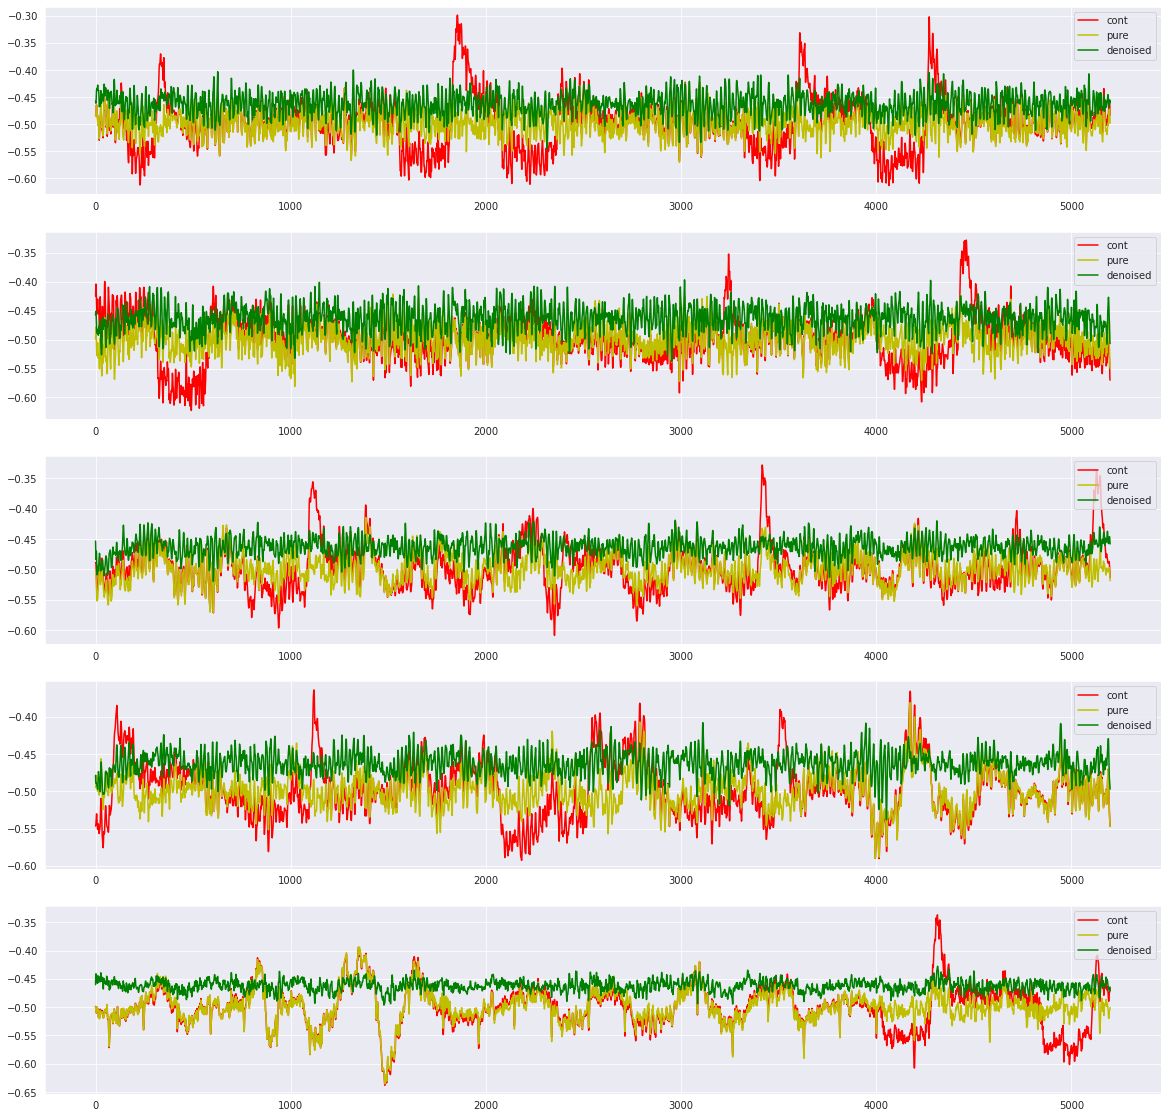

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = train_cont_eeg[idx_segment, idx_ch, :]
        e_pure = train_cleaned_eeg[idx_segment, idx_ch, :]
        e_denoised = train_denoised_eeg[idx_segment, idx_ch,:]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].plot(e_denoised, 'g', label='denoised')
        axs[idx_row].legend(loc='upper right')
        # axs[idx_row].set_ylim(-0.6,0.6)

print(e_cont.shape)
print(e_pure.shape)
print(e_denoised.shape)

plt.show()

In [ ]:
eval_dataset = EEGDataset(cont_eeg=eval_cont_1s_seg, clean_eeg=eval_cleaned_1s_seg)

ld_cont_eval = DataLoader(
    eval_dataset, 
    batch_size=1, 
    shuffle=False, 
    num_workers=n_cpu
)

# ----------
# Evaluating
# ----------
generator.eval()
discriminator.eval()

eval_denoised_1s_eeg = []

with torch.no_grad():
    for i, (cont_eeg, clean_eeg) in enumerate(ld_cont_eval):
        if cuda:
            cont_eeg = cont_eeg.to("cuda")
            clean_eeg = clean_eeg.to("cuda")

        # Generate a high resolution image from low resolution input
        e_denoised_eeg = generator(cont_eeg)
        # GPU to CPU
        e_denoised_eeg = e_denoised_eeg.cpu().detach().numpy()
        # Change type
        e_denoised_eeg = np.float64(e_denoised_eeg)
        eval_denoised_1s_eeg.append(e_denoised_eeg)
        # break
    eval_denoised_1s_eeg = np.array(eval_denoised_1s_eeg)

In [ ]:
print(type(eval_cont_1s_seg))
print(type(eval_cleaned_1s_seg))
print(type(eval_denoised_1s_eeg))

print(eval_cont_1s_seg.shape)
print(eval_cleaned_1s_seg.shape)
print(eval_denoised_1s_eeg.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1404, 19, 200)
(1404, 19, 200)
(1404, 1, 19, 200, 1)


In [ ]:
# Reduce dimensions
eval_denoised_1s_eeg = eval_denoised_1s_eeg.squeeze(1).squeeze(-1)
print(eval_denoised_1s_eeg.shape)

(1404, 19, 200)


In [ ]:
# Combine 26 of 1-s epochs to a 26s epoch
eval_denoised_eeg = []
n_4s_seg = eval_denoised_1s_eeg.shape[0]
skip_rate = 26

for idx_e_seg in range(0,n_4s_seg,skip_rate):
    start_idx = idx_e_seg
    end_idx = start_idx + skip_rate
    list_1s_segs = eval_denoised_1s_eeg[start_idx:end_idx, :, :]
    combined_segment = np.concatenate(list_1s_segs, axis=-1)
    eval_denoised_eeg.append(combined_segment)

eval_denoised_eeg = np.array(eval_denoised_eeg)
print(eval_denoised_eeg.shape)

(54, 19, 5200)


In [ ]:
print(eval_cont_eeg.shape)
print(eval_cleaned_eeg.shape)
print(eval_denoised_eeg.shape)

print(eval_cont_eeg.dtype)
print(eval_cleaned_eeg.dtype)
print(eval_denoised_eeg.dtype)

# print(eval_cont_events.shape)

(54, 19, 5200)
(54, 19, 5200)
(54, 19, 5200)
float64
float32
float64


(5200,)
(5200,)
(5200,)


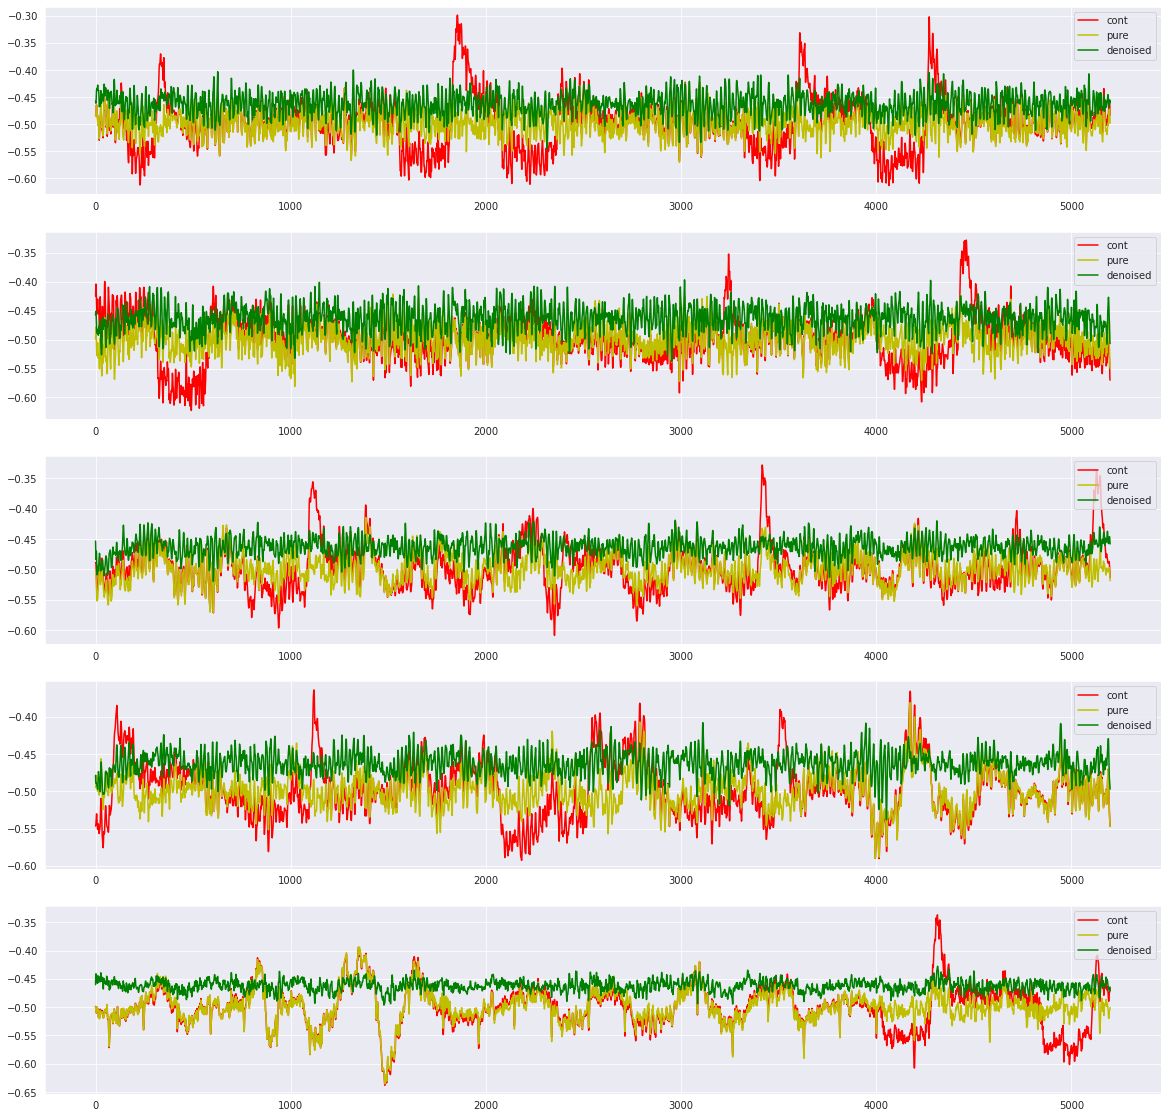

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = eval_cont_eeg[idx_segment, idx_ch, :]
        e_pure = eval_cleaned_eeg[idx_segment, idx_ch, :]
        e_denoised = eval_denoised_eeg[idx_segment, idx_ch,:]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].plot(e_denoised, 'g', label='denoised')
        axs[idx_row].legend(loc='upper right')
        # axs[idx_row].set_ylim(-0.6,0.6)

print(e_cont.shape)
print(e_pure.shape)
print(e_denoised.shape)

plt.show()

In [ ]:
print(train_cont_eeg.shape)
print(train_cleaned_eeg.shape)
print(train_denoised_eeg.shape)

print(train_cont_eeg.dtype)
print(train_cleaned_eeg.dtype)
print(train_denoised_eeg.dtype)

# print(train_cont_events.shape)

print(eval_cont_eeg.shape)
print(eval_cleaned_eeg.shape)
print(eval_denoised_eeg.shape)

print(eval_cont_eeg.dtype)
print(eval_cleaned_eeg.dtype)
print(eval_denoised_eeg.dtype)

# print(eval_cont_events.shape)

(54, 19, 5200)
(54, 19, 5200)
(54, 19, 5200)
float64
float32
float64
(54, 19, 5200)
(54, 19, 5200)
(54, 19, 5200)
float64
float32
float64


In [ ]:
scaled_denoised_eeg = np.concatenate((train_denoised_eeg, eval_denoised_eeg), axis=0)
scaled_denoised_eeg.shape

(108, 19, 5200)

In [ ]:
# De-scaling
de_scaled_cont_eeg = descaling_eeg(scaled_cont_eeg, scaler=cont_scaler)
de_scaled_pure_eeg = descaling_eeg(scaled_pure_eeg, scaler=pure_scaler)
de_scaled_denoised_eeg = descaling_eeg(scaled_denoised_eeg, scaler=pure_scaler)

(5200,)
(5200,)
(5200,)


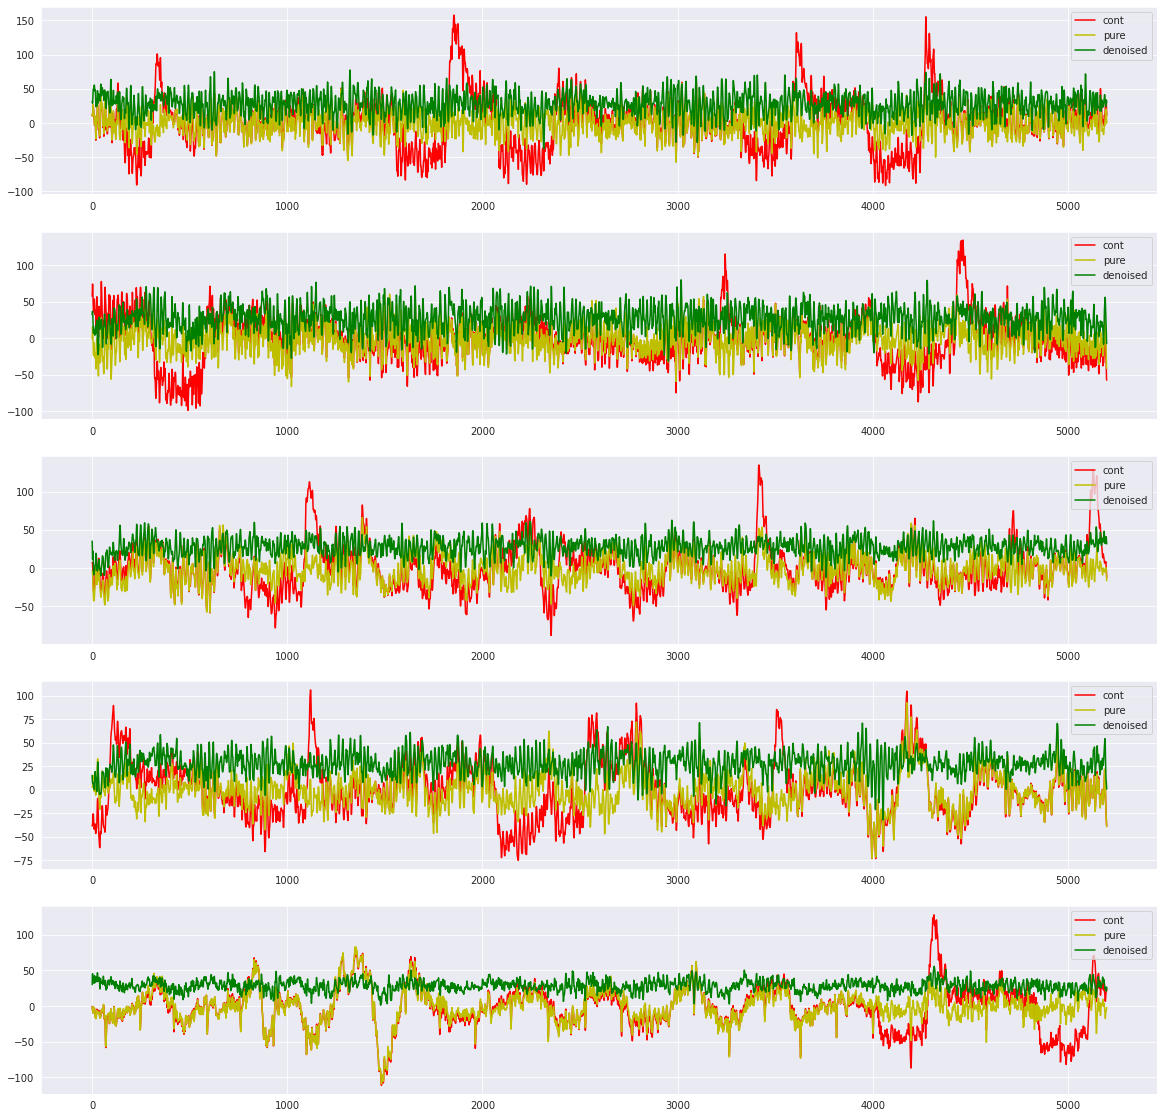

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = de_scaled_cont_eeg[idx_segment, idx_ch, :]
        e_pure = de_scaled_pure_eeg[idx_segment, idx_ch, :]
        e_denoised = de_scaled_denoised_eeg[idx_segment, idx_ch,:]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].plot(e_denoised, 'g', label='denoised')
        axs[idx_row].legend(loc='upper right')
        # axs[idx_row].set_ylim(-0.6,0.6)

print(e_cont.shape)
print(e_pure.shape)
print(e_denoised.shape)

plt.show()

## Performance metrics

In [ ]:
# # Prepare data for calculating metrics
# reconstructed_pure_EEG = np.array(reconstructed_pure_EEG)
# reconstructed_cont_EEG = np.array(reconstructed_cont_EEG)
# denoised_EEG = np.array(denoised_EEG)
# print(reconstructed_pure_EEG.shape)

# # Hyperparameters for calculating metrics
# list_denoised_EEG_keys = list(selectedLength_contEEG.keys())


# # Prepare data for calculating metrics
# reconstructed_pure_EEG = np.array(grab_children(selectedLength_pureEEG))
# reconstructed_cont_EEG = np.array(grab_children(selectedLength_contEEG))
# reconstructed_denoised_EEG = np.array(denoised_EEG)
# print(reconstructed_denoised_EEG.shape)

# Prepare data for calculating metrics
reconstructed_pure_EEG = de_scaled_cont_eeg
reconstructed_cont_EEG = de_scaled_pure_eeg
reconstructed_denoised_EEG = de_scaled_denoised_eeg
print(reconstructed_denoised_EEG.shape)

# Hyperparameters for calculating metrics
NUMBER_SUBJECTS = reconstructed_denoised_EEG.shape[0]
list_denoised_EEG_keys = list(selectedLength_contEEG.keys())
print(list_denoised_EEG_keys)

# Get some samples
print(reconstructed_pure_EEG[0,0,:10])
print(reconstructed_cont_EEG[0,0,:10])
print(reconstructed_denoised_EEG[0,0,:10])

(54, 19, 5200)
['sim1_con', 'sim2_con', 'sim3_con', 'sim4_con', 'sim5_con', 'sim6_con', 'sim7_con', 'sim8_con', 'sim9_con', 'sim10_con', 'sim11_con', 'sim12_con', 'sim13_con', 'sim14_con', 'sim15_con', 'sim16_con', 'sim17_con', 'sim18_con', 'sim19_con', 'sim20_con', 'sim21_con', 'sim22_con', 'sim23_con', 'sim24_con', 'sim25_con', 'sim26_con', 'sim27_con', 'sim28_con', 'sim29_con', 'sim30_con', 'sim31_con', 'sim32_con', 'sim33_con', 'sim34_con', 'sim35_con', 'sim36_con', 'sim37_con', 'sim38_con', 'sim39_con', 'sim40_con', 'sim41_con', 'sim42_con', 'sim43_con', 'sim44_con', 'sim45_con', 'sim46_con', 'sim47_con', 'sim48_con', 'sim49_con', 'sim50_con', 'sim51_con', 'sim52_con', 'sim53_con', 'sim54_con']
[11.31871986 12.29839897 10.28273773 17.45271301 23.6586895  26.45616531
 23.17921638 18.67058563 15.468853   13.17694283]
[11.333832  12.315155  10.298584  17.469849  23.683716  26.498322
 23.249756  18.782013  15.634399  13.4114685]
[15.71738836 17.72357669 16.52781494 23.37681471 32.2822

In [ ]:
# Save Numpy to Files
"""
5 EOG artifact removal techniques
- 'WT'
- 'ICA'
- 'wICA'
- 'WNN'
- 'SRGAN'
"""
ar_techniques = 'SRGAN'

np.save(
    file=f'Result/before_after_removal/{ar_techniques}_pure_EEG',
    arr=reconstructed_pure_EEG,
    allow_pickle=True, fix_imports=True)
np.save(
    file=f'Result/before_after_removal/{ar_techniques}_cont_EEG',
    arr=reconstructed_cont_EEG,
    allow_pickle=True, fix_imports=True)
np.save(
    file=f'Result/before_after_removal/{ar_techniques}_denoised_EEG',
    arr=reconstructed_denoised_EEG,
    allow_pickle=True, fix_imports=True)

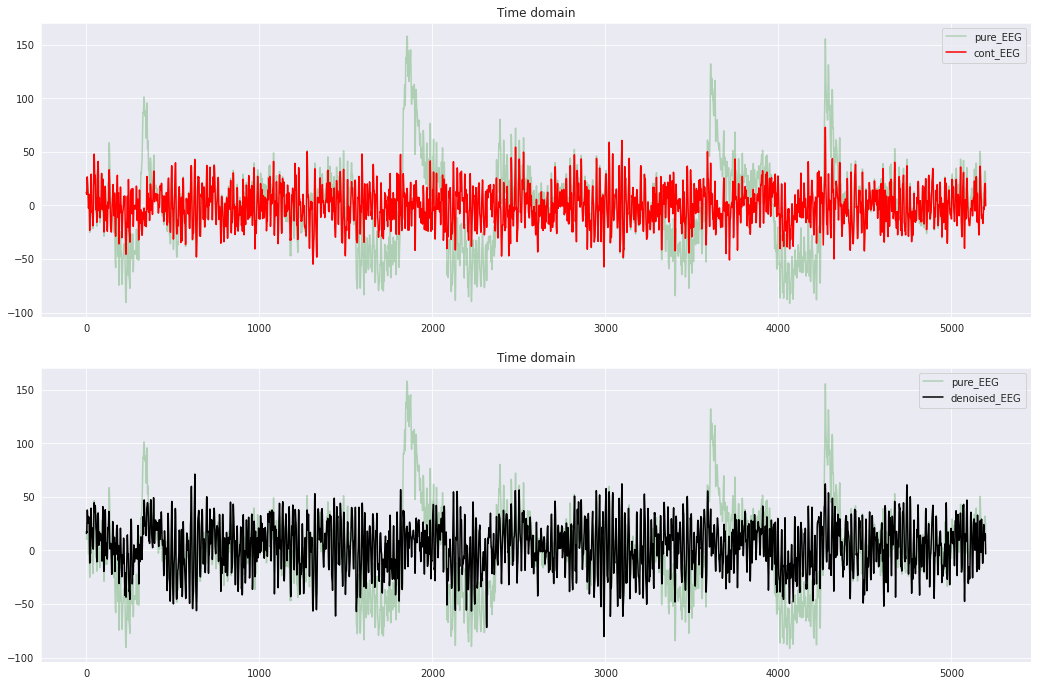

In [ ]:
def createSubplot(n):
    fig,axs = plt.subplots(n,figsize=(15,10))
    fig.tight_layout(pad=3.0)
    return fig,axs

# Prepare subplots
fig, axs = createSubplot(2)
# Select a subject's electrode
selected_idx_subject = 0
selected_idx_electrode = 0

plt.sca(axs[0])
plt.plot(reconstructed_pure_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="pure_EEG", color="g", alpha=0.25)
plt.plot(reconstructed_cont_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="cont_EEG", color="r")
plt.title("Time domain")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(reconstructed_pure_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="pure_EEG", color="g", alpha=0.25)
plt.plot(reconstructed_denoised_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="denoised_EEG", color="k")

plt.title("Time domain")
plt.legend(loc="upper right")

plt.show()

In [ ]:
def calculate_RMSE(pure_EEG_e_CH, denoised_EEG_e_CH):
    """
    Calculate RMSE in dB scale (log based E)
    """
    diff_EEG = pure_EEG_e_CH - denoised_EEG_e_CH
    RMSE = np.mean(np.power(diff_EEG,2))
    return RMSE

def calculate_SAR(cont_EEG_e_CH,denoised_EEG_e_CH):
    """
    Calculate Signal to Artifact Ratio (SAR)
    """
    SAR = 10*np.log(np.std(cont_EEG_e_CH) / np.std(cont_EEG_e_CH-denoised_EEG_e_CH))
    return SAR

def calculate_MSC(cont_EEG_e_CH, denoised_EEG_e_CH):
    """
    Calculate Magnitude Squared Coherence
    """
    MSC = scipy.signal.coherence(x=cont_EEG_e_CH, y=denoised_EEG_e_CH,
                                 fs=200, window='hann', nperseg=200,
                                 noverlap=None, nfft=None, detrend=False,
                                 axis=-1)
    return MSC

def calculate_PSD(EEG_e_CH):
    """
    Calculate Magnitude Squared Coherence
    """
    PSD = scipy.signal.welch(x=EEG_e_CH,
                             fs=200, window='hann', nperseg=200, 
                             noverlap=None, nfft=None, detrend=False,
                             scaling='density',
                             axis=-1)
    return PSD

In [ ]:
pure_denoised_RMSE_subjs = {}

for idx_e_subject in range(number_subjects):
    manyCH_RMSE = []
    manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_RMSE = calculate_RMSE(
            pure_EEG_e_CH=manyCH_pureEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_RMSE.append(oneCH_RMSE)

    pure_denoised_RMSE_subjs[list_denoised_EEG_keys[idx_e_subject]] = manyCH_RMSE
    
# Create DataFrame for RMSE
df_RMSE = pd.DataFrame(data=pure_denoised_RMSE_subjs, 
                      index= EEG_electrodes,
                      columns=pure_denoised_RMSE_subjs.keys())

print(f"Avg. RMSE of each Electrodes: \n{df_RMSE.mean(axis=1)}")
print(f"Grand Avg. RMSE: {np.mean(df_RMSE.mean(axis=1))}")
df_RMSE

Avg. RMSE of each Electrodes: 
Fp1    1113.184835
Fp2    1234.326315
F3      196.014736
F4      391.782154
C3      701.984436
C4      908.523883
P3      934.309756
P4      408.250669
O1      140.688211
O2      222.522497
F7      448.578563
F8     1056.353078
T3      122.395382
T4      238.219600
T5      142.780102
T6      166.746469
Fz      855.901189
Cz     1445.617135
Pz     1533.017978
dtype: float64
Grand Avg. RMSE: 645.3261572700216


sim1_con     sim2_con     sim3_con     sim4_con     sim5_con  \
Fp1  1028.656196   834.626888   675.569688   676.795772   669.873640   
Fp2  1069.127915   851.207221   699.664131   658.271541   605.103172   
F3    279.059393   272.684350   170.144122   173.895226   123.046072   
F4    613.434817   430.319400   370.316100   360.100711   286.346527   
C3    715.768856   710.955040   719.388570   714.063712   720.412285   
C4    936.956294   940.193101   894.026434   884.529553   875.221429   
P3    947.496478   912.975445   927.230569   936.606543   966.219438   
P4    415.874142   386.171199   383.307015   375.599424   342.107027   
O1    160.109735   154.309261   174.922919   191.230842   125.040646   
O2    271.896649   258.303887   237.625793   245.013856   176.034590   
F7    377.284947   346.426594   443.278484   204.925834   266.908844   
F8    897.219935   898.278198  1108.059553   958.064349  1112.294779   
T3    125.756628   113.526213    83.712004    60.191469    79.838741   
T4    215.939737   196.946955   228.297619   196.652456   211.600924   
T5    164.090328   167.497796   163.215743   169.441912   117.927282   
T6    169.595860   174.790746   151.467250   146.558887   129.094744   
Fz    775.814708   749.309008   773.504919   740.999287   710.818664   
Cz   1477.057409  1456.219427  1477.029528  1432.379431  1414.252483   
Pz   1518.331055  1475.520805  1523.656879  1515.022355  1484.846456   

        sim6_con     sim7_con     sim8_con     sim9_con    sim10_con  ...  \
Fp1  1390.298712  1035.631033  1069.401160   882.698266   989.527550  ...   
Fp2  1406.807100  1074.466488  1151.914027   980.858849  1043.150019  ...   
F3    148.608236   166.987421   177.481278   125.649670   134.150957  ...   
F4    355.294038   340.506584   369.020386   331.031836   332.829596  ...   
C3    695.211347   706.012250   705.167588   718.017541   708.313107  ...   
C4    908.195075   892.976114   887.444300   864.306372   882.373286  ...   
P3    975.086974   959.410138   919.709692   985.248629   947.313018  ...   
P4    451.532590   400.813012   403.072897   358.425491   354.766299  ...   
O1    159.286701   152.366964   150.271116   103.603911   101.539189  ...   
O2    214.574189   222.958544   259.064870   192.689911   158.355837  ...   
F7    635.715346   449.216147   467.944887   427.266499   385.128045  ...   
F8   1218.767801  1078.855182   967.663752  1066.664492  1062.043885  ...   
T3    164.231043   120.598862   105.418165   129.672346   112.472380  ...   
T4    282.400164   199.048185   199.336967   226.218337   259.875533  ...   
T5    128.635339   118.357310   118.536216   103.779327    99.962609  ...   
T6    236.910917   149.508512   177.367405   164.247243   132.114437  ...   
Fz    765.114242   736.000558   750.672022   719.416244   767.765964  ...   
Cz   1457.619023  1409.641391  1398.250533  1448.911791  1450.588606  ...   
Pz   1569.059789  1516.254089  1510.952604  1543.046805  1531.341463  ...   

       sim45_con    sim46_con    sim47_con    sim48_con    sim49_con  \
Fp1   824.882484  1625.076190  1736.919017   902.650104  1130.388221   
Fp2   986.686680  1834.808940  5435.345330  1012.778934  1259.224179   
F3    145.946356   176.437694   208.241741   151.945802   155.538114   
F4    338.174284   416.019533   387.527758   350.101592   360.541083   
C3    732.215765   725.012626   729.167777   732.402720   726.641174   
C4    860.792216   867.849666   896.299993   865.267362   875.615108   
P3    961.807763   978.947698   969.927081   970.201078   971.557270   
P4    295.478374   436.631166   466.103499   331.138969   356.693038   
O1    100.656831   121.901364   120.329054   114.681763   135.709230   
O2    115.510396   218.741693   223.334853   145.760372   179.438882   
F7    450.573653   209.002590   467.687516   382.136208   440.795717   
F8   1020.813066   964.429896  1071.940722  1004.053132   976.174081   
T3    104.862712    73.514943   107.023805    73.965058   106.876541   
T4    214.476013  

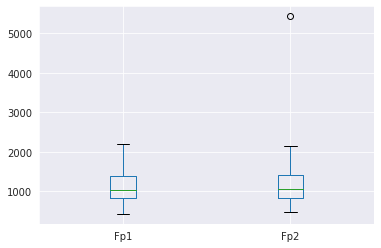

In [ ]:
df_RMSE.copy().transpose().boxplot(['Fp1', 'Fp2'])

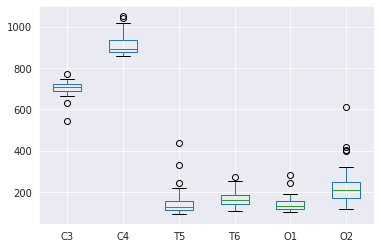

In [ ]:
df_RMSE.copy().transpose().boxplot(['C3', 'C4', 'T5', 'T6', 'O1', 'O2'])

In [ ]:
cont_denoised_SAR_subjs = {}

for idx_e_subject in range(number_subjects):
    manyCH_SAR = []
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_SAR = calculate_SAR(
            cont_EEG_e_CH=manyCH_contEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_SAR.append(oneCH_SAR)

    cont_denoised_SAR_subjs[list_denoised_EEG_keys[idx_e_subject]] = manyCH_SAR
    
# Create DataFrame for SAR
df_SAR = pd.DataFrame(data=cont_denoised_SAR_subjs, 
                      index= EEG_electrodes,
                      columns=cont_denoised_SAR_subjs.keys())

print(f"Avg. SAR of each Electrodes: \n{df_SAR.mean(axis=1)}")
print(f"Grand Avg. SAR: {np.mean(df_SAR.mean(axis=1))}")
df_SAR

Avg. SAR of each Electrodes: 
Fp1    0.743670
Fp2    2.073756
F3     2.544714
F4     5.043667
C3     4.063841
C4     7.699775
P3     6.335415
P4     1.708710
O1     3.658372
O2     0.407549
F7     1.294168
F8    -0.490276
T3    -2.690357
T4     1.023014
T5     1.613428
T6     0.557329
Fz     3.164788
Cz     6.711793
Pz     4.744562
dtype: float64
Grand Avg. SAR: 2.6425220448779005


sim1_con   sim2_con   sim3_con   sim4_con  sim5_con  sim6_con  \
Fp1   1.143380   1.312172   2.538534   1.602172  2.933905  1.021103   
Fp2   2.137437   1.876933   2.128095   2.542591  3.125128  0.617853   
F3    2.501505   3.968127   6.274621   4.606664  7.258153  3.125346   
F4    4.360560   4.649035   6.167168   6.403916  8.479877  3.102626   
C3    6.722977   8.105350   6.490993   7.194468  6.425471  5.298654   
C4    7.476708   7.883662  10.661363   9.562428 -0.425014  0.872003   
P3   10.312091  11.489634   8.203373  10.263090  4.961676  2.728775   
P4    7.582092   8.661134   2.843476   4.684794 -1.481288 -2.377628   
O1    6.648852   7.301956   4.562189   4.440760  2.301556  0.884303   
O2    4.300205   4.823012   1.523897   1.421880 -0.375150 -0.857755   
F7    1.277304   2.270858   4.092093   2.829131  2.856201 -0.102832   
F8    0.471556   1.261159   0.048093   1.482702  2.257127  1.215314   
T3   -1.584908   0.885309  -0.642931  -0.285931 -0.914165 -3.569838   
T4    1.499795   2.535408   1.887535   2.356902  2.602646  0.697294   
T5    5.215875   5.936733   2.657898   3.359851  0.628883 -0.784487   
T6    4.207247   4.256479   0.421929   0.944113 -0.870453  0.869143   
Fz    5.666613   9.766121   7.121515   6.224876  7.387600  1.044202   
Cz    7.356687  10.190781   8.010624   8.692238  8.297604  6.469515   
Pz   10.571063  11.167514   6.657627   9.465960  1.830992  1.399522   

      sim7_con   sim8_con  sim9_con  sim10_con  ...  sim45_con  sim46_con  \
Fp1   2.816301   2.651438 -0.418892  -0.482629  ...   0.172886   0.132199   
Fp2   3.081281   3.748269  0.834477   1.967224  ...   2.437934   1.085027   
F3    5.409179   3.399734 -0.802974  -0.202651  ...  -0.393126  -2.117963   
F4    5.969570   6.477683  1.967043   5.243052  ...   3.962095   0.367096   
C3    6.311660   3.097491 -0.483122   0.461957  ...   1.981926  -0.038026   
C4    8.320851  10.052131  6.935095  10.004574  ...   7.357225   7.369619   
P3    3.740474   5.047207  2.621506   1.956599  ...   9.168241  11.878220   
P4    1.542431   0.737229 -3.977592  -1.631339  ...   4.376000   2.671208   
O1    4.118977   4.146932  3.210028   3.028410  ...   4.676232   5.757418   
O2    2.531304   0.219613 -2.449688   0.205807  ...   0.519831  -3.241783   
F7    2.200527   3.453143 -0.384421   0.488172  ...   1.491062   0.712691   
F8    0.003660  -1.009026 -4.081286  -2.524736  ...  -0.713415  -3.926312   
T3   -1.571058  -3.420730 -3.623974  -4.604149  ...  -4.518804  -6.918123   
T4    0.217362   0.805435 -1.884545  -0.104567  ...   2.593122  -2.162341   
T5    0.517484   1.549664  0.098982  -0.050272  ...   2.483896   3.553794   
T6    1.782098   0.392797 -2.681835   0.616147  ...   1.922595  -0.332414   
Fz    4.403455   4.660540 -3.016076  -2.295549  ...   0.701972  -3.322425   
Cz   10.238355   8.483588  4.145811   4.170096  ...   6.401303   5.997343   
Pz    6.181671   5.669968 -0.166331  -1.028836  ...   7.307679   8.828381   

     sim47_con  sim48_con  sim49_con  sim50_con  sim51_con  sim52_con  \
Fp1  -3.273086   0.122167  -1.628469  -1.525477   0.392734   2.069932   
Fp2  -0.694216   2.663599   0.358895   3.367147  -1.787025   2.011514   
F3   -4.021154  -1.473149  -1.717868  -3.061980  -0.597107   1.269612   
F4    2.040987   4.524506   2.481799   4.343214  -0.694237   3.605817   
C3   -1.802480  -0.610961   0.352124  -1.822289   0.810444   1.031868   
C4    6.514889   9.704479   9.349766   8.257971   7.589799   6.505933   
P3    2.394943   6.495570   6.453061   4.360241   6.430888   6.084839   
P4   -2.316945   2.338403  -0.100051  -1.949216  -0.227329  -1.528248   
O1    1.657141   5.875840   4.321095   3.628452   4.022735   4.832249   
O2   -1.925354  -0.063990  -0.983253  -2.271818  -0.525209  -2.995423   
F7   -1.485311   0.045165  -0.441812   0.128280   1.413367   2.402091   
F8   -5.992582  -3.133277  -6.753236  -4.029461  -9.123351  -4.931435   
T3  -10.489387  -8.125687  -7.318399  -7.800680  -2.932994  -5.047201   
T4   -2.002769   0.134

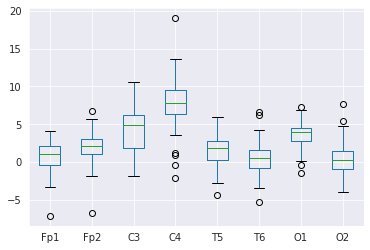

In [ ]:
df_SAR.copy().transpose().boxplot(['Fp1','Fp2','C3', 'C4', 'T5', 'T6', 'O1', 'O2'])

The shape of cont_denoised_MSC_subjs: (54, 19, 2, 101)


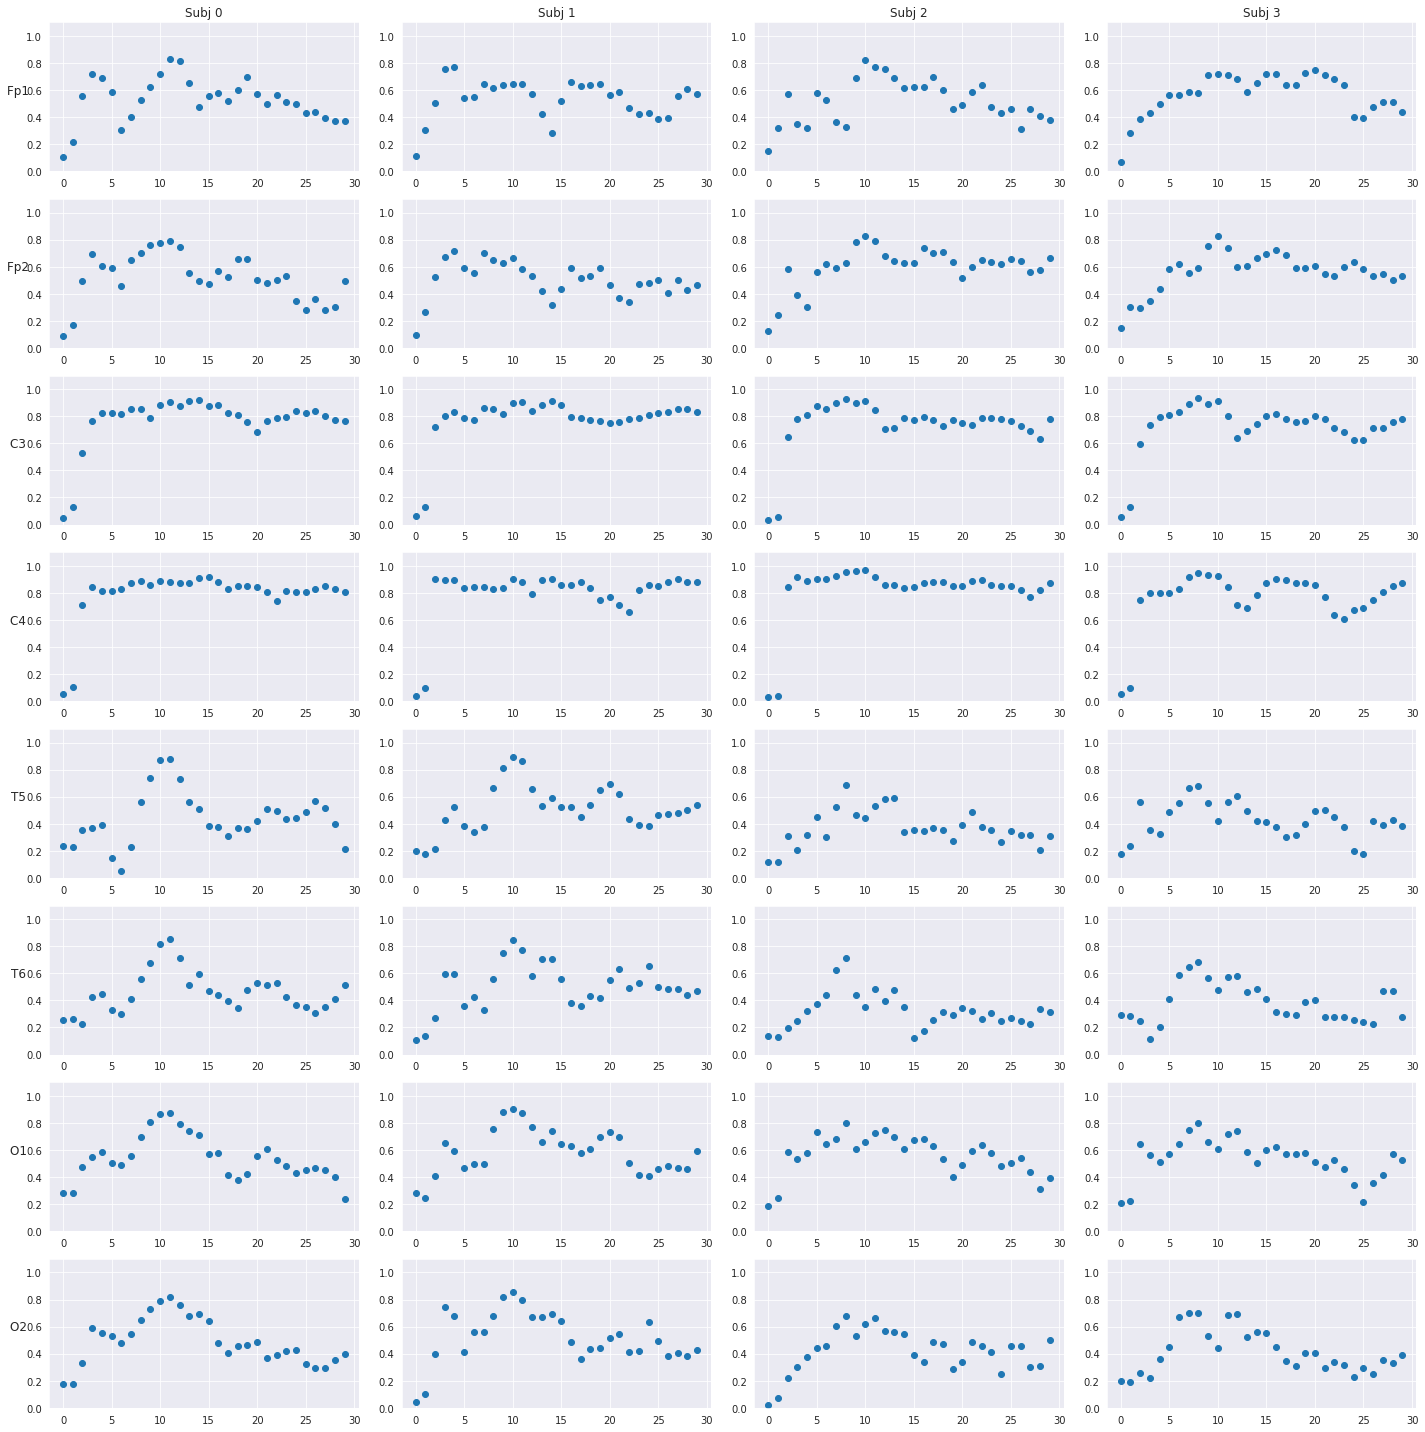

In [ ]:
cont_denoised_MSC_subjs = []

for idx_e_subject in range(number_subjects):
    manyCH_MSC = []
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_MSC = calculate_MSC(
            cont_EEG_e_CH=manyCH_contEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_MSC.append(oneCH_MSC)

    cont_denoised_MSC_subjs.append(manyCH_MSC)

cont_denoised_MSC_subjs = np.array(cont_denoised_MSC_subjs)
print(f'The shape of cont_denoised_MSC_subjs: {cont_denoised_MSC_subjs.shape}')

list_selected_electrodes_indices = [EEG_electrodes.index('Fp1'), EEG_electrodes.index('Fp2'),
                                    EEG_electrodes.index('C3'), EEG_electrodes.index('C4'),
                                    EEG_electrodes.index('T5'), EEG_electrodes.index('T6'),
                                    EEG_electrodes.index('O1'), EEG_electrodes.index('O2'),]
list_selected_electrodes = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1', 'O2']


# Plot MSC
fig, axs = plt.subplots(nrows=int(len(list_selected_electrodes_indices)),
                        ncols=4, figsize=(20,20))

cols = ['Subj {}'.format(col) for col in range(4)]
rows = ['{}  '.format(row) for row in list_selected_electrodes]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
    
for idx_e_ch, e_ch in enumerate(list_selected_electrodes_indices):
    l_freq = 0
    h_freq = 30

    axs[idx_e_ch,0].scatter(
        cont_denoised_MSC_subjs[0,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[0,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,0].set_ylim(0,1.1)

    axs[idx_e_ch,1].scatter(
        cont_denoised_MSC_subjs[1,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[1,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,1].set_ylim(0,1.1)

    axs[idx_e_ch,2].scatter(
        cont_denoised_MSC_subjs[2,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[2,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,2].set_ylim(0,1.1)

    axs[idx_e_ch,3].scatter(
        cont_denoised_MSC_subjs[3,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[3,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,3].set_ylim(0,1.1)

fig.tight_layout()
plt.show()

The shape of pure_PSD_subjs: (54, 19, 2, 101)
The shape of cont_PSD_subjs: (54, 19, 2, 101)
The shape of denoised_PSD_subjs: (54, 19, 2, 101)


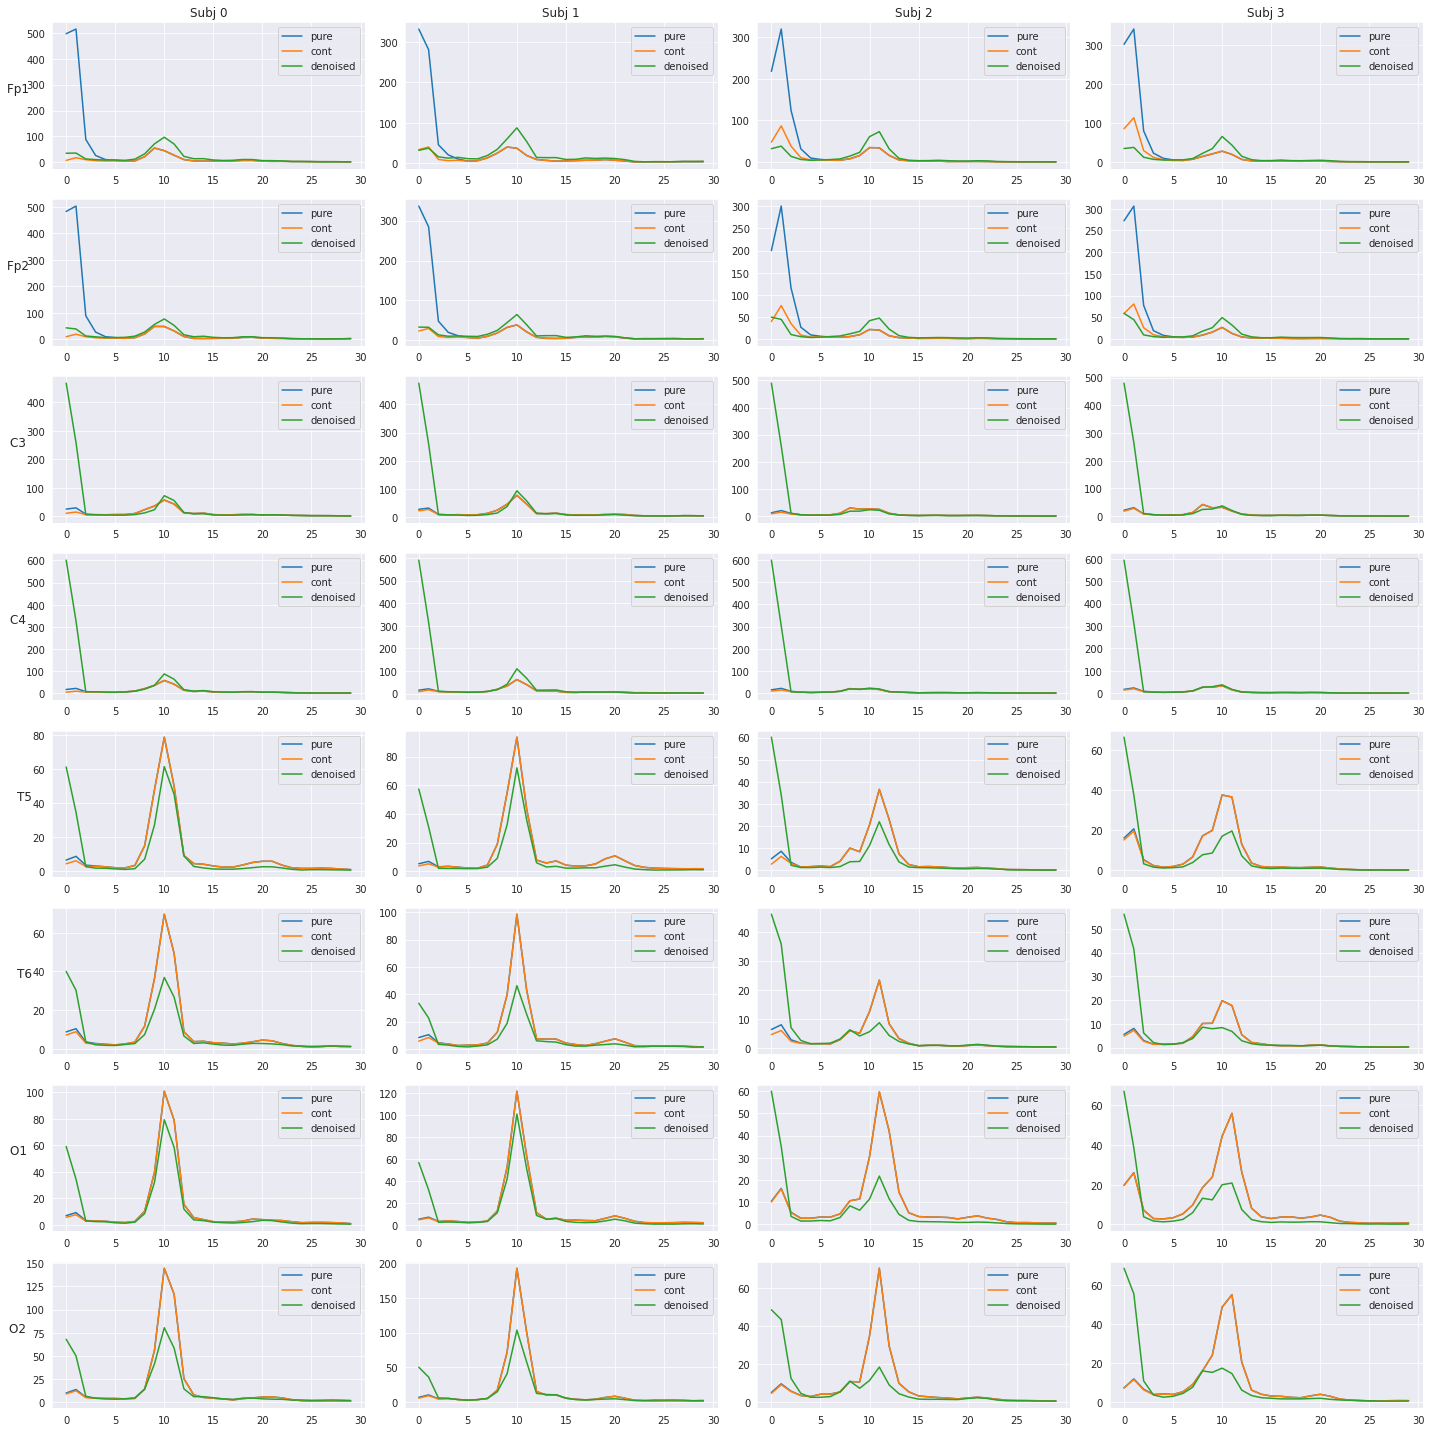

In [ ]:
pure_PSD_subjs = []
cont_PSD_subjs = []
denoised_PSD_subjs = []

for idx_e_subject in range(number_subjects):
    pure_PSD_CHs = []
    cont_PSD_CHs = []
    denoised_PSD_CHs = []

    manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_pure_PSD = calculate_PSD(manyCH_pureEEG[idx_channel])
        oneCH_cont_PSD = calculate_PSD(manyCH_contEEG[idx_channel])
        oneCH_denoised_PSD = calculate_PSD(manyCH_denoisedEEG[idx_channel])

        pure_PSD_CHs.append(oneCH_pure_PSD)
        cont_PSD_CHs.append(oneCH_cont_PSD)
        denoised_PSD_CHs.append(oneCH_denoised_PSD)

    pure_PSD_subjs.append(pure_PSD_CHs)
    cont_PSD_subjs.append(cont_PSD_CHs)
    denoised_PSD_subjs.append(denoised_PSD_CHs)

pure_PSD_subjs = np.array(pure_PSD_subjs)
cont_PSD_subjs = np.array(cont_PSD_subjs)
denoised_PSD_subjs = np.array(denoised_PSD_subjs)

print(f'The shape of pure_PSD_subjs: {pure_PSD_subjs.shape}')
print(f'The shape of cont_PSD_subjs: {cont_PSD_subjs.shape}')
print(f'The shape of denoised_PSD_subjs: {denoised_PSD_subjs.shape}')

list_selected_electrodes_indices = [EEG_electrodes.index('Fp1'), EEG_electrodes.index('Fp2'),
                                    EEG_electrodes.index('C3'), EEG_electrodes.index('C4'),
                                    EEG_electrodes.index('T5'), EEG_electrodes.index('T6'),
                                    EEG_electrodes.index('O1'), EEG_electrodes.index('O2'),]
list_selected_electrodes = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1', 'O2']

# Plot PSD
fig, axs = plt.subplots(nrows=int(len(list_selected_electrodes_indices)),
                        ncols=4, figsize=(20,20))

cols = ['Subj {}'.format(col) for col in range(4)]
rows = ['{}  '.format(row) for row in list_selected_electrodes]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
    
for idx_e_ch, e_ch in enumerate(list_selected_electrodes_indices):
    l_freq = 0
    h_freq = 30

    axs[idx_e_ch,0].plot(
        pure_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].plot(
        cont_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].plot(
        denoised_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,1].plot(
        pure_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[1,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,1].plot(
        cont_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[1,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,1].plot(
        denoised_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[1,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,1].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,2].plot(
        pure_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[2,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,2].plot(
        cont_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[2,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,2].plot(
        denoised_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[2,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,2].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,3].plot(
        pure_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[3,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,3].plot(
        cont_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[3,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,3].plot(
        denoised_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[3,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,3].legend(['pure', 'cont', 'denoised'])

fig.tight_layout()
plt.show()

# Save metrics

In [ ]:
!pwd
df_RMSE.to_csv(path_or_buf='save_results/05_SRGAN_RMSE.csv', 
               sep=',', float_format=None)
df_SAR.to_csv(path_or_buf='save_results/05_SRGAN_SAR.csv', 
               sep=',', float_format=None)


/content/drive/MyDrive/Colab Notebooks/Thesis_st121166
